<a href="https://colab.research.google.com/github/saif9402/Dr-Wessam-Project/blob/main/N_grams_Feature_Extarction_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  # File upload and Kaggle dataset setup
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ammaryasser19","key":"9acc2572d12903dd7a75ccc06d507498"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d anupampaul005/fake-news-dataset
!unzip fake-news-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/anupampaul005/fake-news-dataset
License(s): MIT
Archive:  fake-news-dataset.zip
  inflating: dataset.csv             


In [ ]:

# Imports
import os
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np


In [ ]:
# Load dataset
print(os.listdir())
df = pd.read_csv('dataset.csv')
df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df['label'] = df['unreliable']
print(df[['title', 'text', 'content', 'label']].head())


['.config', 'kaggle.json', 'dataset.csv', 'fake-news-dataset.zip', 'sample_data']
                                               title  \
0  WARNING: A Pivotal Moment For The Stock Market...   
1  Trump, top defense officials, discuss North Ko...   
2  British civil servants' union calls nationwide...   
3   A**hole Of The Day – Michele Bachmann: Muslim...   
4  ’Deport Fat People’ Posters Appear At CU Bould...   

                                                text  \
0  WARNING: A Pivotal Moment For The Stock Market...   
1  WASHINGTON  - U.S. President Donald Trump met ...   
2  LONDON  - British civil servants will vote nex...   
3  Michele Bachmann has been pretty quiet since l...   
4  Posters calling on Donald Trump to “Deport Fat...   

                                             content  label  
0  WARNING: A Pivotal Moment For The Stock Market...      1  
1  Trump, top defense officials, discuss North Ko...      0  
2  British civil servants' union calls nationwide...      

In [ ]:

# Preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    words = [w for w in text.split() if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

df['cleaned_content'] = df['content'].apply(preprocess)
df = df[df['cleaned_content'].str.split().str.len() > 5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df['cleaned_content'])
y = df['label']
print("✅ TF-IDF shape:", X_tfidf.shape)
print("✅ Labels shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

✅ TF-IDF shape: (65539, 5000)
✅ Labels shape: (65539,)


In [ ]:
#ROC curve

def plot_roc_curve(y_true, y_proba, model_name='Model'):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Logistic Regression Accuracy: 0.9651
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      6418
           1       0.96      0.97      0.97      6690

    accuracy                           0.97     13108
   macro avg       0.97      0.97      0.97     13108
weighted avg       0.97      0.97      0.97     13108



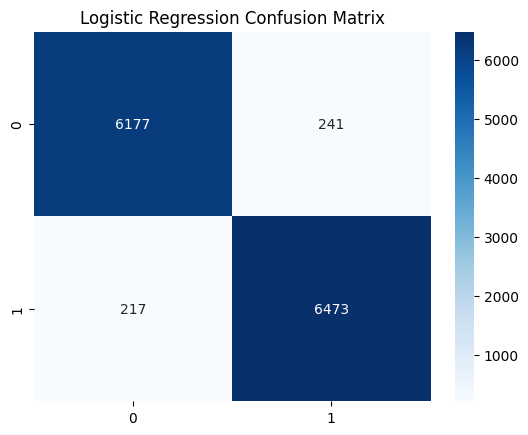

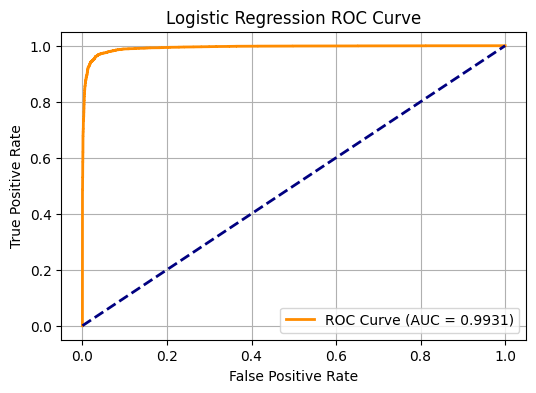

In [ ]:

# Logistic Regression (with GridSearch)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=3, n_jobs=-1, verbose=2)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
print(f"\nLogistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_lr, 'Logistic Regression')


Random Forest Accuracy: 0.9650
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      6418
           1       0.97      0.96      0.97      6690

    accuracy                           0.96     13108
   macro avg       0.96      0.97      0.96     13108
weighted avg       0.97      0.96      0.96     13108



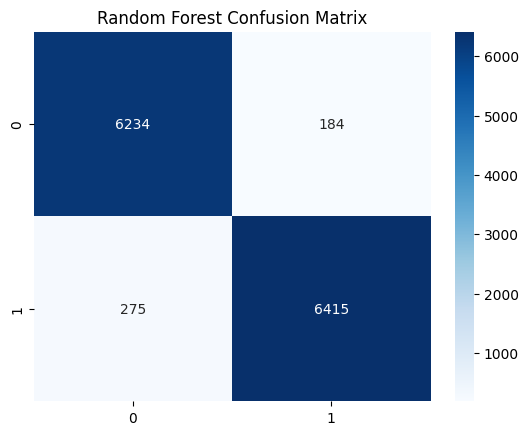

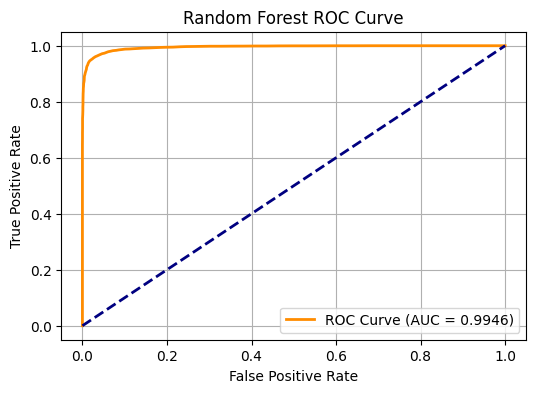

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"\nRandom Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()


y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_rf, 'Random Forest')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:33:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 0.9722
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6418
           1       0.98      0.97      0.97      6690

    accuracy                           0.97     13108
   macro avg       0.97      0.97      0.97     13108
weighted avg       0.97      0.97      0.97     13108



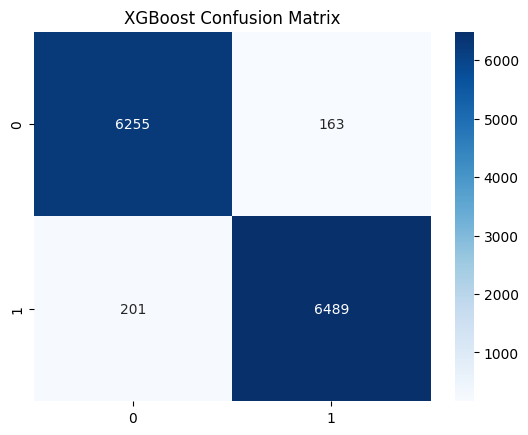

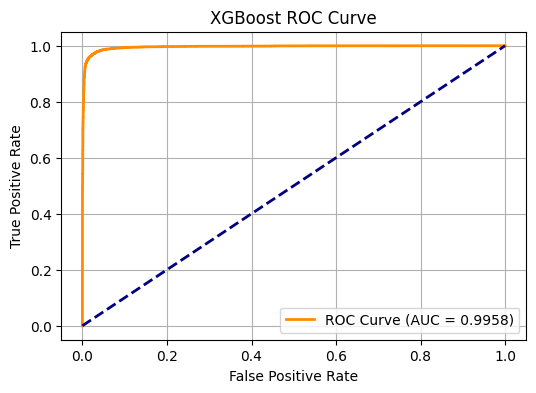

In [ ]:
# XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print(f"\nXGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()


y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_xgb, 'XGBoost')



Naive Bayes Accuracy: 0.8734
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      6418
           1       0.86      0.90      0.88      6690

    accuracy                           0.87     13108
   macro avg       0.87      0.87      0.87     13108
weighted avg       0.87      0.87      0.87     13108



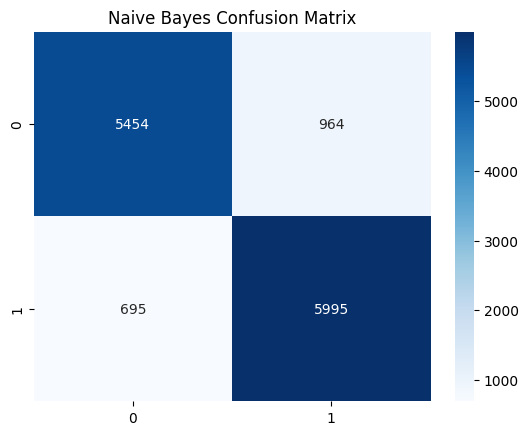

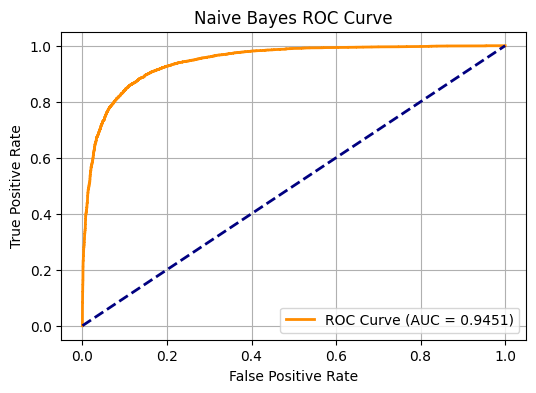

In [ ]:

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(f"\nNaive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(classification_report(y_test, y_pred_nb))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.show()



y_pred_proba_nb = nb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_nb, 'Naive Bayes')

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


656/656 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.8850 - loss: 0.2829 - val_accuracy: 0.9417 - val_loss: 0.1710
Epoch 2/5
656/656 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9569 - loss: 0.1333 - val_accuracy: 0.9554 - val_loss: 0.1280
Epoch 3/5
656/656 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9650 - loss: 0.1038 - val_accuracy: 0.9654 - val_loss: 0.1192
Epoch 4/5
656/656 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9810 - loss: 0.0614 - val_accuracy: 0.9685 - val_loss: 0.1018
Epoch 5/5
656/656 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9861 - loss: 0.0452 - val_accuracy: 0.9524 - val_loss: 0.1312
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9520 - loss: 0.1329

LSTM Model Accuracy: 0.9530
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


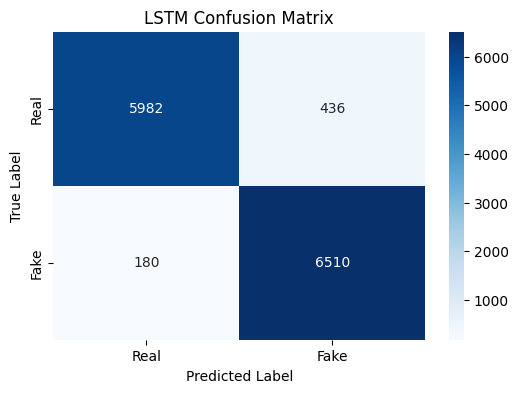

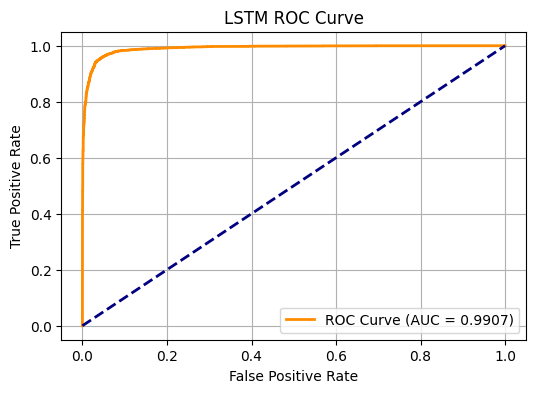


Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.93      0.95      6418
        Fake       0.94      0.97      0.95      6690

    accuracy                           0.95     13108
   macro avg       0.95      0.95      0.95     13108
weighted avg       0.95      0.95      0.95     13108



In [ ]:
# LSTM Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_content'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_content'])
X_pad = pad_sequences(X_seq, maxlen=300)
y_dl = df['label'].values

# Train-test split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_pad, y_dl, test_size=0.2, random_state=42)

# LSTM Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=300))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train model (Epochs: 5)
history = model.fit(X_train_dl, y_train_dl, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stop])

# Evaluate model
loss, acc = model.evaluate(X_test_dl, y_test_dl)
print(f"\nLSTM Model Accuracy: {acc:.4f}")

# Predict
y_pred_dl = model.predict(X_test_dl)
y_pred_labels = (y_pred_dl > 0.5).astype(int)

# Confusion matrix
cm_dl = confusion_matrix(y_test_dl, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



y_pred_proba_dl = y_pred_dl.flatten()
plot_roc_curve(y_test_dl, y_pred_proba_dl, 'LSTM')
# Classification report
print("\nClassification Report:")
print(classification_report(y_test_dl, y_pred_labels, target_names=['Real', 'Fake']))
